In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import glob
import itertools
from PIL import Image
from tqdm import tqdm
from pathlib import Path
from PIL import Image
import cv2
from IPython.display import display, Image, clear_output
import ipywidgets as widgets
import threading
from sklearn.metrics import f1_score, recall_score


cudnn.benchmark = True
plt.ion()   # interactive mode

In [36]:
# ADAPTED FROM THE PROFESSOR'S PYTORCH NOTEBOOK

# For straightforward datasets, sometimes you can make do with built-in PyTorch dataset objects.
# We want to apply automated data augmentations, which will be different for the training
# and eval scenarios

data_transforms = {
    x: transforms.Compose([
#         transforms.ToPILImage(),
        transforms.RandomRotation(degrees=10),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.01, .5)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    for x in ['train', 'val']
}

data_transforms['test'] = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [37]:
data_dir = './data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test', 'val']}

In [38]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0, drop_last=True)
              for x in ['train', 'test', 'val']}

In [39]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test', 'val']}
class_names = image_datasets['train'].classes

print(dataset_sizes)
print(class_names)

{'train': 1619, 'test': 100, 'val': 170}
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [40]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
device = 'cpu'
print(device)

cpu


In [41]:
print(torch.backends.mps.is_available()) #the MacOS is higher than 12.3+
print(torch.backends.mps.is_built()) #MPS is activated

True
True


In [42]:
# Let’s visualize a few training images so as to understand the data augmentations.
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

torch.Size([4, 3, 299, 299])
tensor([13,  6, 18, 24])
torch.Size([3, 303, 1206])


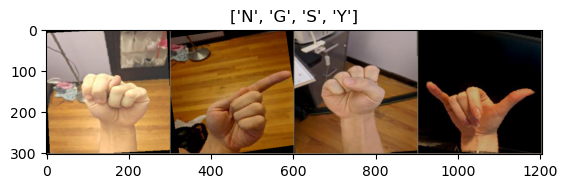

In [43]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
print(inputs.shape)
print(classes)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
print(out.shape)

imshow(out, title=[class_names[x] for x in classes])

In [44]:
# Now, let’s write a general function to train a model.
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [45]:
# Load a pretrained model and reset final fully connected layer for this particular classification problem.
model_resnet = models.resnet18(weights=True)

model_inception = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1)
model_inception.aux_logits=False

# model_mobilenet = models.mobilenet_v3_small(pretrained=True)

trained_models = {
    "resnet": model_resnet,
    "inception": model_inception,
#     "mobilenet": model_mobilenet
}



for k in trained_models.keys():
    num_ftrs = trained_models[k].fc.in_features
    trained_models[k].fc = nn.Linear(num_ftrs, len(class_names))
    trained_models[k] = trained_models[k].to(device)
    

/Users/akash/anaconda3/envs/new-acv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [46]:
# Let's set our loss function
criterion = nn.CrossEntropyLoss()

In [47]:
# for k in trained_models.keys():
for k in ['resnet', 'inception']:
    print(f"TRAINING {k}")
    # setup the optimizer to update the model parameters
    optimizer_ft = optim.SGD(trained_models[k].parameters(), lr=0.0005, momentum=0.9)
    
    # decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
                                           
    # train and evaluate.
    trained_models[k] = train_model(trained_models[k], criterion, optimizer_ft, exp_lr_scheduler,
                           num_epochs=10)
    print("\n\n\n")                        

TRAINING resnet
Epoch 0/9
----------


100%|█████████████████████████████████████████| 404/404 [01:33<00:00,  4.34it/s]


train Loss: 2.9508 Acc: 0.1618


100%|███████████████████████████████████████████| 42/42 [00:03<00:00, 10.75it/s]


val Loss: 2.0464 Acc: 0.4294

Epoch 1/9
----------


100%|█████████████████████████████████████████| 404/404 [01:33<00:00,  4.32it/s]


train Loss: 1.7417 Acc: 0.5361


100%|███████████████████████████████████████████| 42/42 [00:03<00:00, 11.00it/s]


val Loss: 1.0344 Acc: 0.6882

Epoch 2/9
----------


100%|█████████████████████████████████████████| 404/404 [01:33<00:00,  4.30it/s]


train Loss: 1.0275 Acc: 0.7684


100%|███████████████████████████████████████████| 42/42 [00:03<00:00, 10.83it/s]


val Loss: 0.6473 Acc: 0.8000

Epoch 3/9
----------


100%|█████████████████████████████████████████| 404/404 [01:33<00:00,  4.33it/s]


train Loss: 0.6424 Acc: 0.8579


100%|███████████████████████████████████████████| 42/42 [00:04<00:00, 10.19it/s]


val Loss: 0.5169 Acc: 0.8176

Epoch 4/9
----------


100%|█████████████████████████████████████████| 404/404 [01:35<00:00,  4.22it/s]


train Loss: 0.4083 Acc: 0.9228


100%|███████████████████████████████████████████| 42/42 [00:04<00:00, 10.15it/s]


val Loss: 0.4756 Acc: 0.8353

Epoch 5/9
----------


100%|█████████████████████████████████████████| 404/404 [01:35<00:00,  4.24it/s]


train Loss: 0.3095 Acc: 0.9358


100%|███████████████████████████████████████████| 42/42 [00:03<00:00, 10.64it/s]


val Loss: 0.4676 Acc: 0.8235

Epoch 6/9
----------


100%|█████████████████████████████████████████| 404/404 [01:35<00:00,  4.22it/s]


train Loss: 0.2347 Acc: 0.9537


100%|███████████████████████████████████████████| 42/42 [00:04<00:00, 10.25it/s]


val Loss: 0.4048 Acc: 0.8529

Epoch 7/9
----------


100%|█████████████████████████████████████████| 404/404 [01:36<00:00,  4.20it/s]


train Loss: 0.1737 Acc: 0.9734


100%|███████████████████████████████████████████| 42/42 [00:04<00:00, 10.12it/s]


val Loss: 0.3543 Acc: 0.8882

Epoch 8/9
----------


100%|█████████████████████████████████████████| 404/404 [01:35<00:00,  4.21it/s]


train Loss: 0.1643 Acc: 0.9741


100%|███████████████████████████████████████████| 42/42 [00:04<00:00, 10.37it/s]


val Loss: 0.3414 Acc: 0.8706

Epoch 9/9
----------


100%|█████████████████████████████████████████| 404/404 [01:35<00:00,  4.23it/s]


train Loss: 0.1438 Acc: 0.9827


100%|███████████████████████████████████████████| 42/42 [00:04<00:00, 10.19it/s]


val Loss: 0.4028 Acc: 0.8588

Training complete in 16m 28s
Best val Acc: 0.888235




TRAINING inception
Epoch 0/9
----------


100%|█████████████████████████████████████████| 404/404 [02:52<00:00,  2.34it/s]


train Loss: 3.0138 Acc: 0.1507


100%|███████████████████████████████████████████| 42/42 [00:06<00:00,  6.39it/s]


val Loss: 2.3784 Acc: 0.3412

Epoch 1/9
----------


100%|█████████████████████████████████████████| 404/404 [02:53<00:00,  2.33it/s]


train Loss: 1.9339 Acc: 0.4929


100%|███████████████████████████████████████████| 42/42 [00:06<00:00,  6.82it/s]


val Loss: 1.0901 Acc: 0.6941

Epoch 2/9
----------


100%|█████████████████████████████████████████| 404/404 [02:51<00:00,  2.36it/s]


train Loss: 1.0537 Acc: 0.7597


100%|███████████████████████████████████████████| 42/42 [00:06<00:00,  6.69it/s]


val Loss: 0.6082 Acc: 0.8118

Epoch 3/9
----------


100%|█████████████████████████████████████████| 404/404 [02:54<00:00,  2.32it/s]


train Loss: 0.5781 Acc: 0.8746


100%|███████████████████████████████████████████| 42/42 [00:06<00:00,  6.76it/s]


val Loss: 0.4629 Acc: 0.8471

Epoch 4/9
----------


100%|█████████████████████████████████████████| 404/404 [02:53<00:00,  2.33it/s]


train Loss: 0.3574 Acc: 0.9290


100%|███████████████████████████████████████████| 42/42 [00:06<00:00,  6.78it/s]


val Loss: 0.3364 Acc: 0.8765

Epoch 5/9
----------


100%|█████████████████████████████████████████| 404/404 [02:55<00:00,  2.31it/s]


train Loss: 0.2458 Acc: 0.9561


100%|███████████████████████████████████████████| 42/42 [00:06<00:00,  6.35it/s]


val Loss: 0.3505 Acc: 0.8824

Epoch 6/9
----------


100%|█████████████████████████████████████████| 404/404 [02:53<00:00,  2.33it/s]


train Loss: 0.1630 Acc: 0.9722


100%|███████████████████████████████████████████| 42/42 [00:06<00:00,  6.57it/s]


val Loss: 0.2747 Acc: 0.9176

Epoch 7/9
----------


100%|█████████████████████████████████████████| 404/404 [02:52<00:00,  2.34it/s]


train Loss: 0.1382 Acc: 0.9796


100%|███████████████████████████████████████████| 42/42 [00:06<00:00,  6.76it/s]


val Loss: 0.2065 Acc: 0.9235

Epoch 8/9
----------


100%|█████████████████████████████████████████| 404/404 [02:53<00:00,  2.33it/s]


train Loss: 0.1283 Acc: 0.9796


100%|███████████████████████████████████████████| 42/42 [00:06<00:00,  6.44it/s]


val Loss: 0.3229 Acc: 0.8941

Epoch 9/9
----------


100%|█████████████████████████████████████████| 404/404 [02:52<00:00,  2.34it/s]


train Loss: 0.1114 Acc: 0.9833


100%|███████████████████████████████████████████| 42/42 [00:06<00:00,  6.70it/s]

val Loss: 0.3767 Acc: 0.8882

Training complete in 29m 56s
Best val Acc: 0.923529






In [50]:
def test_model(model):

    model.eval() # eval mode (not training anymore)
    running_corrects = 0
    
    all_predictions = []
    all_labels = []

    # iterate over the test dataset
    for inputs, labels in tqdm(dataloaders['test']):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        all_labels += labels.tolist()
        

        # make predictions
        with torch.set_grad_enabled(False):
            outputs = model(inputs).squeeze(1)
            _, preds = torch.max(outputs, 1)
            all_predictions += preds.tolist()

            # statistics
            running_corrects += torch.sum(preds == labels.data)

    # return accuracy
    accuracy = running_corrects.double() / dataset_sizes['test']
    f1 = f1_score(all_labels, all_predictions, average="macro")
    recall = recall_score(all_labels, all_predictions, average="macro")
    return {"accuracy": accuracy.item(), "f1": f1, "recall": recall}

In [51]:
for k in trained_models.keys():
    print(f"{k} accuracy: {test_model(trained_models[k])}")
    torch.save(trained_models[k].state_dict(), os.path.abspath(f"./models/{k}"))

100%|███████████████████████████████████████████| 25/25 [00:02<00:00, 11.18it/s]


resnet accuracy: {'accuracy': 0.84, 'f1': 0.8161029141798372, 'recall': 0.8397435897435896}


100%|███████████████████████████████████████████| 25/25 [00:03<00:00,  6.87it/s]


inception accuracy: {'accuracy': 0.88, 'f1': 0.870801420801421, 'recall': 0.8826923076923077}


In [ ]:
# #https://abauville.medium.com/display-your-live-webcam-feed-in-a-jupyter-notebook-using-opencv-d01eb75921d1

# chosen_model = "inception"

# # stop button
# stopButton = widgets.ToggleButton(
#     value=False,
#     description='Stop',
#     disabled=False,
#     button_style='danger',
#     tooltip='Description',
#     icon='square'
# )


# # display function
# def view(button):
#     cap = cv2.VideoCapture(0)
#     display_handle=display(None, display_id=True)
#     i = 0
#     while True:
#         _, frame = cap.read()
#         frame = cv2.flip(frame, 1)
        
#         # crop and resize the frame
#         crop_width, crop_height = 299, 299

#         # Get the dimensions of the image
#         height, width = frame.shape[:2]

#         # Calculate coordinates for the crop
#         start_x = (width - crop_width) // 2
#         start_y = (height - crop_height) // 2

#         # Crop the image
#         cropped_image = frame[start_y:start_y + crop_height, start_x:start_x + crop_width]
        
# #         frame = cv2.resize(frame, dsize=(299, 299), interpolation=cv2.INTER_CUBIC)
    
        
#         frame = cropped_image.astype(np.float32)

#         new_frame = data_transforms["test"](frame / 255).unsqueeze(0)

#         with torch.no_grad():
#             pred = class_names[torch.argmax(trained_models[chosen_model](new_frame))] + ' ' + str(torch.max(nn.Softmax()(trained_models[chosen_model](new_frame))).item())
       
#         font = cv2.FONT_HERSHEY_SIMPLEX 
#         cv2.putText(frame,  
#                 pred,  
#                 (50, 50),  
#                 font, 1,  
#                 (0, 255, 255),  
#                 2,  
#                 cv2.LINE_4) 
        
#         _, frame = cv2.imencode('.jpeg', frame)
        
#         display_handle.update(Image(data=frame.tobytes()))
#         if stopButton.value==True:
#             cap.release()
#             display_handle.update(None)

            
# # run
# display(stopButton)
# thread = threading.Thread(target=view, args=(stopButton,))
# thread.start()

## 